# Big Bench Hard

In [ ]:
import numpy as np
from datasets import load_dataset
import tqdm
from torch.utils.data import DataLoader
import sys
import pickle as pkl
sys.path.append("../")

from train import train_ensemble


hf_token = ""

In [2]:
bbh_ds_names = ["boolean_expressions",  "causal_judgement",  "date_understanding",  "disambiguation_qa",  "formal_fallacies",  "geometric_shapes",  "hyperbaton",  "logical_deduction_five_objects",  "logical_deduction_seven_objects",  "logical_deduction_three_objects",  "movie_recommendation",  "navigate",  "object_counting",  "penguins_in_a_table",  "reasoning_about_colored_objects",  "ruin_names",  "salient_translation_error_detection",  "snarks",  "sports_understanding",  "temporal_sequences",  "tracking_shuffled_objects_five_objects",  "tracking_shuffled_objects_seven_objects",  "tracking_shuffled_objects_three_objects",  "web_of_lies"]

In [3]:
all_model_data = {
    "meta-llama__Llama-2-70b-chat-hf": {},
    "mistralai__Mixtral-8x7B-Instruct-v0.1" : {},
    "google__gemma-7b": {},
    "microsoft__phi-2": {},
    "mistralai__Mistral-7B-v0.1": {},
}

model_names = list(all_model_data.keys())

In [4]:
def load_data(model_name, ds_name):
    data = load_dataset(
    f"HuggingFaceEvalInternal/{model_name}-details-private",
    name=f"{model_name}__leaderboard_bbh_{ds_name}",
    split="latest",
    token=hf_token)

    idx = np.argsort(data["doc_id"])

    probs = np.array(data["resps"]).squeeze()[:, :, 0].astype(float)
    labels = np.array([data["doc"][i]["target"] for i in range(len(probs))])
    choices = sorted(list(set(labels)))
    labels_list = [choices.index(lbl) for lbl in labels]
    label_arr = np.array(labels_list).astype(int)

    return probs[idx], label_arr[idx]

for mn in list(all_model_data.keys()):
    print(mn)
    for ds_name in tqdm.tqdm(bbh_ds_names):
        x, y = load_data(mn, ds_name)
        all_model_data[mn][ds_name] = {
            "data" : x,
            "label": y
        }

with open("bbh_data.pkl", "wb") as f:
    pkl.dump(model_names, f)

meta-llama__Llama-2-70b-chat-hf


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


mistralai__Mixtral-8x7B-Instruct-v0.1


100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


google__gemma-7b


100%|██████████| 24/24 [00:25<00:00,  1.08s/it]


microsoft__phi-2


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


mistralai__Mistral-7B-v0.1


100%|██████████| 24/24 [00:26<00:00,  1.10s/it]


In [6]:
with open("bbh_data.pkl", "rb") as f:
    all_model_data = pkl.load(f)

meta-llama__Llama-2-70b-chat-hf


100%|██████████| 24/24 [00:23<00:00,  1.01it/s]


mistralai__Mixtral-8x7B-Instruct-v0.1


100%|██████████| 24/24 [00:24<00:00,  1.03s/it]


google__gemma-7b


100%|██████████| 24/24 [00:25<00:00,  1.08s/it]


microsoft__phi-2


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


mistralai__Mistral-7B-v0.1


100%|██████████| 24/24 [00:25<00:00,  1.04s/it]


In [5]:
results = {}
for ds_name in tqdm.tqdm(bbh_ds_names):
    results[ds_name] = {}
    all_x, all_y = [], []
    for mn in all_model_data.keys():
        x, y = all_model_data[mn][ds_name].values()
        all_x.append(x)
        all_y.append(y)
    all_x = np.concatenate(all_x, axis=1)

    try:
        for y_idx in all_y:
            for i in range(len(y_idx)):
                assert(y_idx[i] == y[i])
    except AssertionError as e:
        print(e)
        print(f"skipping ... {ds_name}")

    concat_data = np.concatenate([all_x, y[:, None]], axis=1)

    train_size = int(len(x) * 0.8)
    train_data, test_data = concat_data[:train_size], concat_data[train_size:]

    val_size = int(len(train_data) * 0.2)
    train_size = len(train_data) - val_size

    novel_data = test_data[:, :-1]
    novel_label = test_data[:, -1]
    for i, novel_arr in enumerate(np.split(novel_data, len(model_names), axis=1)):
        pred = novel_arr.argmax(axis=1)
        acc = np.mean(novel_label == pred)
        print(f"{model_names[i]}: Acc: {acc:.4f}")
        results[ds_name][model_names[i]] = acc * 100


    batch_size = 4
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(train_data[train_size:], batch_size=batch_size, shuffle=True)
    novel_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    space_size = all_x[0].shape[0] // len(model_names)

    exp_result = train_ensemble(model_names, train_loader, val_loader, novel_loader,
                    n_epochs=300, save_dir=".",
                    space_size=space_size, verbose=False)
    results[ds_name]["TOPLA"] = exp_result["test_acc"]
    print(exp_result["test_acc"])


  0%|          | 0/24 [00:00<?, ?it/s]

/home/stekin6/sft/inference_llm/other_results/../train.py:77: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


meta-llama__Llama-2-70b-chat-hf: Acc: 0.6600
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.9400
google__gemma-7b: Acc: 0.8200
microsoft__phi-2: Acc: 0.9200
mistralai__Mistral-7B-v0.1: Acc: 0.8200


  4%|▍         | 1/24 [00:06<02:26,  6.37s/it]

No improvement in 200 epochs, breaking
Novel Acc = 94.2308 +- 5.73
94.23076923076923
meta-llama__Llama-2-70b-chat-hf: Acc: 0.3684
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.3158
google__gemma-7b: Acc: 0.2895
microsoft__phi-2: Acc: 0.4474
mistralai__Mistral-7B-v0.1: Acc: 0.4211


/home/stekin6/sft/inference_llm/other_results/../train.py:77: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)
  8%|▊         | 2/24 [00:12<02:17,  6.27s/it]

Novel Acc = 62.5000 +- 15.88
62.5
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1800
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5600
google__gemma-7b: Acc: 0.4000
microsoft__phi-2: Acc: 0.4200
mistralai__Mistral-7B-v0.1: Acc: 0.4800


 12%|█▎        | 3/24 [00:20<02:28,  7.09s/it]

Novel Acc = 59.6154 +- 11.36
59.61538461538461
meta-llama__Llama-2-70b-chat-hf: Acc: 0.2600
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5600
google__gemma-7b: Acc: 0.5600
microsoft__phi-2: Acc: 0.8200
mistralai__Mistral-7B-v0.1: Acc: 0.4200


 17%|█▋        | 4/24 [00:28<02:29,  7.47s/it]

Novel Acc = 76.9231 +- 12.46
76.92307692307692
meta-llama__Llama-2-70b-chat-hf: Acc: 0.4600
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.4400
google__gemma-7b: Acc: 0.5000
microsoft__phi-2: Acc: 0.5200
mistralai__Mistral-7B-v0.1: Acc: 0.4800


 21%|██        | 5/24 [00:36<02:26,  7.69s/it]

Novel Acc = 57.6923 +- 9.81
57.69230769230769
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.0000
google__gemma-7b: Acc: 0.0600
microsoft__phi-2: Acc: 0.0000
mistralai__Mistral-7B-v0.1: Acc: 0.0400


 25%|██▌       | 6/24 [00:42<02:07,  7.08s/it]

No improvement in 200 epochs, breaking
Novel Acc = 36.5385 +- 15.65
36.53846153846154
meta-llama__Llama-2-70b-chat-hf: Acc: 0.5200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.8200
google__gemma-7b: Acc: 0.6200
microsoft__phi-2: Acc: 0.8400
mistralai__Mistral-7B-v0.1: Acc: 0.5800


 29%|██▉       | 7/24 [00:49<01:57,  6.89s/it]

No improvement in 200 epochs, breaking
Novel Acc = 90.3846 +- 6.61
90.38461538461539
meta-llama__Llama-2-70b-chat-hf: Acc: 0.2600
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5200
google__gemma-7b: Acc: 0.2000
microsoft__phi-2: Acc: 0.5000
mistralai__Mistral-7B-v0.1: Acc: 0.4400


 33%|███▎      | 8/24 [00:57<01:56,  7.26s/it]

Novel Acc = 46.1538 +- 16.73
46.15384615384615
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1400
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.3000
google__gemma-7b: Acc: 0.3200
microsoft__phi-2: Acc: 0.5200
mistralai__Mistral-7B-v0.1: Acc: 0.2600


 38%|███▊      | 9/24 [01:05<01:52,  7.53s/it]

Novel Acc = 30.7692 +- 9.47
30.76923076923077
meta-llama__Llama-2-70b-chat-hf: Acc: 0.4200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5000
google__gemma-7b: Acc: 0.5600
microsoft__phi-2: Acc: 0.7600
mistralai__Mistral-7B-v0.1: Acc: 0.6200


 42%|████▏     | 10/24 [01:12<01:45,  7.57s/it]

No improvement in 200 epochs, breaking
Novel Acc = 76.9231 +- 11.26
76.92307692307692
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1400
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.6600
google__gemma-7b: Acc: 0.5600
microsoft__phi-2: Acc: 0.7000
mistralai__Mistral-7B-v0.1: Acc: 0.6800


 46%|████▌     | 11/24 [01:21<01:40,  7.73s/it]

Novel Acc = 73.0769 +- 15.51
73.07692307692308
meta-llama__Llama-2-70b-chat-hf: Acc: 0.5200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.2600
google__gemma-7b: Acc: 0.4400
microsoft__phi-2: Acc: 0.4000
mistralai__Mistral-7B-v0.1: Acc: 0.5000


 50%|█████     | 12/24 [01:29<01:33,  7.82s/it]

Novel Acc = 71.1538 +- 12.89
71.15384615384616
meta-llama__Llama-2-70b-chat-hf: Acc: 0.0400
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.0600
google__gemma-7b: Acc: 0.1200
microsoft__phi-2: Acc: 0.0000
mistralai__Mistral-7B-v0.1: Acc: 0.1200


 54%|█████▍    | 13/24 [01:35<01:19,  7.27s/it]

No improvement in 200 epochs, breaking
Novel Acc = 23.0769 +- 9.92
23.076923076923077
meta-llama__Llama-2-70b-chat-hf: Acc: 0.2333
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5000
google__gemma-7b: Acc: 0.4667
microsoft__phi-2: Acc: 0.4667
mistralai__Mistral-7B-v0.1: Acc: 0.4333


 58%|█████▊    | 14/24 [01:39<01:05,  6.50s/it]

Novel Acc = 37.5000 +- 12.25
37.5
meta-llama__Llama-2-70b-chat-hf: Acc: 0.0800
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5800
google__gemma-7b: Acc: 0.3400
microsoft__phi-2: Acc: 0.3400
mistralai__Mistral-7B-v0.1: Acc: 0.2800


 62%|██████▎   | 15/24 [01:45<00:55,  6.19s/it]

No improvement in 200 epochs, breaking
Novel Acc = 15.3846 +- 10.03
15.384615384615385
meta-llama__Llama-2-70b-chat-hf: Acc: 0.2200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.5600
google__gemma-7b: Acc: 0.3400
microsoft__phi-2: Acc: 0.4000
mistralai__Mistral-7B-v0.1: Acc: 0.5600


 67%|██████▋   | 16/24 [01:53<00:54,  6.81s/it]

Novel Acc = 55.7692 +- 14.26
55.76923076923077
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.4000
google__gemma-7b: Acc: 0.2200
microsoft__phi-2: Acc: 0.4200
mistralai__Mistral-7B-v0.1: Acc: 0.4400


 71%|███████   | 17/24 [02:01<00:50,  7.19s/it]

Novel Acc = 44.2308 +- 10.86
44.23076923076923
meta-llama__Llama-2-70b-chat-hf: Acc: 0.4444
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.6944
google__gemma-7b: Acc: 0.6389
microsoft__phi-2: Acc: 0.6389
mistralai__Mistral-7B-v0.1: Acc: 0.5833


 75%|███████▌  | 18/24 [02:06<00:39,  6.54s/it]

No improvement in 200 epochs, breaking
Novel Acc = 72.2222 +- 9.25
72.22222222222223
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.2400
google__gemma-7b: Acc: 0.1200
microsoft__phi-2: Acc: 0.4000
mistralai__Mistral-7B-v0.1: Acc: 0.2400


 79%|███████▉  | 19/24 [02:12<00:30,  6.20s/it]

No improvement in 200 epochs, breaking
Novel Acc = 86.5385 +- 10.14
86.53846153846153
meta-llama__Llama-2-70b-chat-hf: Acc: 0.3000
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.4600
google__gemma-7b: Acc: 0.1400
microsoft__phi-2: Acc: 0.1800
mistralai__Mistral-7B-v0.1: Acc: 0.1400


 83%|████████▎ | 20/24 [02:20<00:27,  6.75s/it]

Novel Acc = 50.0000 +- 11.92
50.0
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.1400
google__gemma-7b: Acc: 0.0800
microsoft__phi-2: Acc: 0.1600
mistralai__Mistral-7B-v0.1: Acc: 0.0400


 88%|████████▊ | 21/24 [02:28<00:21,  7.15s/it]

Novel Acc = 23.0769 +- 13.55
23.076923076923077
meta-llama__Llama-2-70b-chat-hf: Acc: 0.1200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.1600
google__gemma-7b: Acc: 0.0800
microsoft__phi-2: Acc: 0.1600
mistralai__Mistral-7B-v0.1: Acc: 0.0400


 92%|█████████▏| 22/24 [02:36<00:14,  7.45s/it]

Novel Acc = 5.7692 +- 5.73
5.769230769230769
meta-llama__Llama-2-70b-chat-hf: Acc: 0.3200
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.3200
google__gemma-7b: Acc: 0.3800
microsoft__phi-2: Acc: 0.2600
mistralai__Mistral-7B-v0.1: Acc: 0.3200


 96%|█████████▌| 23/24 [02:44<00:07,  7.63s/it]

Novel Acc = 42.3077 +- 15.44
42.30769230769231
meta-llama__Llama-2-70b-chat-hf: Acc: 0.5600
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.6000
google__gemma-7b: Acc: 0.4400
microsoft__phi-2: Acc: 0.4200
mistralai__Mistral-7B-v0.1: Acc: 0.5800


100%|██████████| 24/24 [02:52<00:00,  7.19s/it]

Novel Acc = 65.3846 +- 12.54
65.38461538461539


In [6]:
avg_scores = {mn: 0 for mn in model_names}
avg_scores["TOPLA"] = 0
for ds_name, res in results.items():
    for mn, acc in res.items():
        avg_scores[mn] += acc

for mn in model_names:
    avg_scores[mn] = avg_scores[mn] / len(results.keys())
avg_scores["TOPLA"] /= len(results.keys())

In [7]:
avg_scores

{'meta-llama__Llama-2-70b-chat-hf': 28.025828460038984,
 'mistralai__Mixtral-8x7B-Instruct-v0.1': 44.1259746588694,
 'google__gemma-7b': 36.22928849902534,
 'microsoft__phi-2': 44.553849902534104,
 'mistralai__Mistral-7B-v0.1': 39.65716374269007,
 'TOPLA': 54.050925925925924}

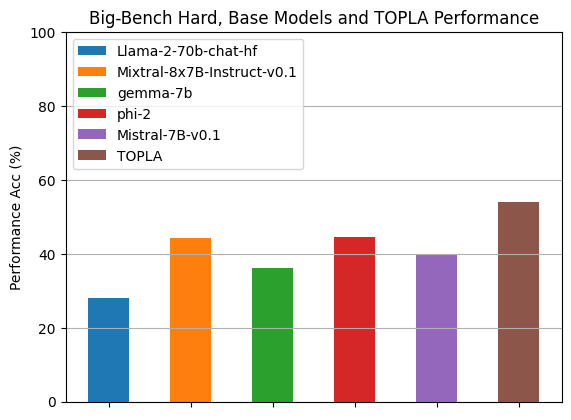

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

width = 0.5  # the width of the bars
multiplier = 0
mstrip_names = []
x = np.arange(len(avg_scores.keys()))
for i, (mn, acc) in enumerate(avg_scores.items()):
    strip_name = mn.split("__")
    strip_name = strip_name[1] if len(strip_name) == 2 else strip_name[0]
    offset = width * multiplier
    rects = ax.bar(x[i] + offset, acc, width, label=strip_name, color=f"C{i}")
    # mstrip_names.append(strip_name)

ax.set_ylabel('Performance Acc (%)')
ax.set_title('Big-Bench Hard, Base Models and TOPLA Performance')
ax.set_xticks(x, mstrip_names, rotation=10)
ax.legend(loc='upper left')
ax.set_ylim(0, 100)
ax.yaxis.grid(zorder=0)
plt.show()
